In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

# Setup

In [3]:
EXPERIMENT = 8

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].set_index('pid').copy()
pdf.query('completed', inplace=True)
full_pdf = pdf.copy()
mdf = data['trials'].set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

## Demographics

In [5]:
pids = list(pdf.index.unique())
sdf = data['survey'].rename(columns={'wid': 'pid'}).query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))
age.loc[age < 18] = None

write_tex('mean-age', f'${age.mean():.1f}$')
write_tex('min-age', f'${age.min():.0f}$')
write_tex('max-age', f'${age.max():.0f}$')

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
n_fem = gender.value_counts()['female']
write_tex("N-female", f'${n_fem}$')

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.train_height.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")
    
write_tex('mean-bonus', f'\${pdf.bonus.mean():.2f}')

wrote "$33.7$" to "stats/8/mean-age.tex"
wrote "$18$" to "stats/8/min-age.tex"
wrote "$67$" to "stats/8/max-age.tex"
wrote "$70$" to "stats/8/N-female.tex"
wrote "$187$" to "stats/8/N-total.tex"
wrote "$63$" to "stats/8/N-1.tex"
wrote "$62$" to "stats/8/N-3.tex"
wrote "$62$" to "stats/8/N-2.tex"
wrote "\$1.28" to "stats/8/mean-bonus.tex"


In [5]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)
mdf['train_height'] = pdf.train_height

In [6]:
with open('mouselab_maxscores.json') as f:
    maxscores = json.load(f)
train_envs = {1: 'minimal', 2: 'easy', 3: 'basic'}
each_max = mdf.apply(lambda row: 
    maxscores['big_cheap'] 
    if row.block == 'test' 
    else maxscores[train_envs[row.train_height]]
, axis=1)
mdf.score *= (100/each_max)

In [7]:
# pdf.train_height = pd.Categorical(pdf.train_height, [1,2,3], ordered=True)    
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

assert set(mdf.index.unique()) == set(pdf.index.unique())

In [8]:
def get_leaves(train_height):
    branch = {
        1: "3",
        2: "3-1",
        3: "3-1-2",
    }[train_height]
    fn = f"structures/{branch}.json"
    with open(fn) as f:
        graph = json.load(f)['graph']
        return set(int(k) for k, v in graph.items() if not v)
    

all_leaves = { th: get_leaves(th) for th in [1,2,3]}
all_leaves['test'] = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if row.block != 'test' and row.train_height == 1:
        return np.nan
    if not row.clicks:
        return 0.
    first = row.clicks[0]
    leaves = all_leaves['test' if row.block == 'test' else row.train_height]
    return float(first in leaves)

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)
pdf['backward'] = mdf.query('block == "test"').groupby('pid').backward.mean()

## Setup Plotting 

In [9]:
mdf

,block,delays,score,trial_index,trial_time,clicks,n_clicks,stim_i,clicked,train_height,backward
pid,,,,,,,,,,,
17,training,"[0, 0, 3, 0]",-174.358974,0,23.739,"[2, 1, 3]",3,0,True,1,NaN
17,training,"[0, 0, 0, 0]",71.794872,1,49.591,"[2, 1, 3]",3,1,True,1,NaN
17,training,"[0, 0, 0, 0]",-92.307692,2,8.664,"[3, 1, 2]",3,2,True,1,NaN
17,training,"[0, 0, 0, 0]",71.794872,3,8.068,"[1, 2, 3]",3,3,True,1,NaN
17,training,"[0, 3, 3, 0]",153.846154,4,13.279,"[2, 3, 1]",3,4,True,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
178,test,[],11.176019,25,20.965,"[9, 5, 7, 10, 11, 6, 21, 20, 17, 18, 22, 16, 2...",19,143,True,3,1.0
178,test,[],13.411222,26,18.252,"[9, 10, 7, 5, 6, 11, 27, 29, 28, 32, 33, 31, 2...",18,157,True,3,1.0
178,test,[],17.881630,27,9.326,"[9, 10]",2,124,True,3,1.0


In [10]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf', 'png']).plot

sns.set_style('whitegrid')
blue, orange, green, _, purple = sns.color_palette('tab10')[:5]
gray = (0.5,)*3
red = (1, 0.3, 0.4)
yellow = (1, 0.9, 0.4)
palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}

palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
    1: purple,
    2: green,
    3: orange
}

nice_names = {
    'meta': 'Metacognitive',
    'action': 'Action',
    'none': 'None',
    'feedback': 'Feedback',
    'info_only': 'Information\nOnly',
    'reward_only': 'Reward\nOnly',
    'both': 'Information &\nReinforcement',
    'score': 'Relative Score',
    'test': 'Relative Test Score',
    'backward': 'Proportion Planning Backward',
    '1': 'Minimal',
    '2': 'Easy',
    '3': 'Difficult',
    'train_height': 'Training Complexity',
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None, drop_title=False):
    if ax is None:
        ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if drop_title:
        handles = handles[1:]
        labels = labels[1:]
    ax.legend(handles=handles, labels=[nice_names.get(l, l).replace('\n', ' ') 
                                       for l in labels])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Bootstrap utils

In [11]:
def ci(x, interval=95):
    a = (1 - (interval / 100)) / 2
    return np.quantile(x, [a, 1-a])

def boot_mean_ci(x, interval=95, n=10000):
    x = pd.Series(x)
    means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
    return ci(means, interval)

def report_means_ci(g, name, units='',  **kws):
    if name is None:
        name = values.name
    for k, d in g:
        x = d.mean()
        a, b = boot_mean_ci(d, **kws)
        tex = rf'${x:.2f}$ {units}; 95\% CI: [${a:.2f}$, ${b:.2f}$]'
        write_tex(f'{name}-mean-{k}', tex)

# Test score

In [12]:
pdf['test_early'] = mdf\
.query('10 <= trial_index < 15')\
.groupby('pid').score.mean()
pdf['backward_early'] = mdf\
.query('10 <= trial_index < 15')\
.groupby('pid').backward.mean()

In [13]:
def write_kruskal(name):
    out = %R kruskal.test($name ~ train_height, data=rdf)
    out = dict(out.items())
    df = out["parameter"][0]
    p = pval(out["p.value"][0])
    stat = out["statistic"][0]
    write_tex(f'{name}-kruskal', rf'$H = {stat:.3f}, {p}$')

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std =  np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

import re
def write_independence_test(y, a, b, alternative='two.sided'):
    # oddly, train_height == b tests a > b
    out = %R independence_test($y ~ train_height == "$b",\
                               data=filter(rdf, train_height %in% c("$a", "$b")),\
                               alternative="$alternative")
    out = str(out)
    match = re.search('Z = (.*), p-value = (.*)', out)
    try:
        z, p = map(float, match.groups())
    except:
        print('Cannot parse independence test')
        print(out)
        raise Exception()
    
    x = rdf.set_index('train_height')[y]
    d = cohen_d(x.loc[a], x.loc[b])
    write_tex(f'independence-{y}-{a}-{b}', f'$d = {d:.2f}, Z = {z:.2f}, {pval(p)}$')

rdf = pdf[['test', 'train_height', 'test_early', 'backward', 'backward_early']]
rdf.train_height = 'T' + rdf.train_height.astype(str)

/usr/local/lib/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
%%R -i rdf
library(dplyr)
library(coin)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: survival



figs/8/test.pdf
figs/8/test.png


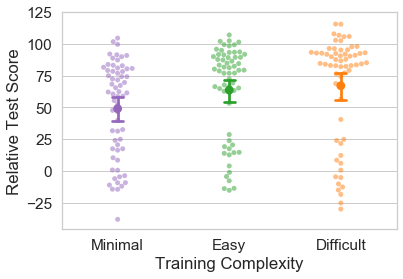

In [15]:
@figure()
def plot_test():
    if EXPERIMENT == 4:
        plt.figure(figsize=(12,4))

    sns.swarmplot('train_height', 'test', data=pdf, palette=palette, alpha=0.5)
    sns.pointplot('train_height', 'test', data=pdf, palette=palette, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('Training Complexity')
    plt.ylabel(nice_names['test'])
    test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    

In [16]:
write_kruskal('test')

wrote "$H = 14.807, p < .001$" to "stats/8/test-kruskal.tex"


In [17]:
report_means_ci(pdf.groupby('train_height').test, 'test', 'points')

wrote "$49.10$ points; 95\% CI: [$39.77$, $58.28$]" to "stats/8/test-mean-1.tex"
wrote "$63.69$ points; 95\% CI: [$54.32$, $72.59$]" to "stats/8/test-mean-2.tex"
wrote "$67.08$ points; 95\% CI: [$56.51$, $76.94$]" to "stats/8/test-mean-3.tex"


In [18]:
write_independence_test('test', 'T2', 'T1')
write_independence_test('test', 'T3', 'T1')
write_independence_test('test', 'T3', 'T2')

wrote "$d = 0.40, Z = 2.18, p = .029$" to "stats/8/independence-test-T2-T1.tex"
wrote "$d = 0.45, Z = 2.49, p = .013$" to "stats/8/independence-test-T3-T1.tex"
wrote "$d = 0.09, Z = 0.48, p = .628$" to "stats/8/independence-test-T3-T2.tex"


## Early test trials

In [19]:
write_kruskal('test_early')

wrote "$H = 28.772, p < .001$" to "stats/8/test_early-kruskal.tex"


In [20]:
report_means_ci(pdf.groupby('train_height').test, 'test_early', 'points')

wrote "$49.10$ points; 95\% CI: [$39.88$, $57.93$]" to "stats/8/test_early-mean-1.tex"
wrote "$63.69$ points; 95\% CI: [$54.76$, $72.21$]" to "stats/8/test_early-mean-2.tex"
wrote "$67.08$ points; 95\% CI: [$56.11$, $76.97$]" to "stats/8/test_early-mean-3.tex"


In [21]:
write_independence_test('test_early', 'T2', 'T1')
write_independence_test('test_early', 'T3', 'T1')
write_independence_test('test_early', 'T3', 'T2')

wrote "$d = 0.83, Z = 4.29, p < .001$" to "stats/8/independence-test_early-T2-T1.tex"
wrote "$d = 0.78, Z = 4.08, p < .001$" to "stats/8/independence-test_early-T3-T1.tex"
wrote "$d = 0.04, Z = 0.21, p = .831$" to "stats/8/independence-test_early-T3-T2.tex"


In [22]:
def improvement_contrast(x):
    m = x.groupby('train_height').mean()
    return (m[2] - m[1]) - (m[3] - m[2])

def permutation_test(f, x, n=10000):
    empirical = f(x)
    x = x.copy()
    boot = np.zeros(n)
    for i in range(n):
        np.random.shuffle(x.values)
        boot[i] = f(x)
    return np.mean(abs(boot) >= abs(empirical))
    
d = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['score', 'train_height']].mean()\
    .set_index('train_height').score

p = permutation_test(improvement_contrast, d)
write_tex('test_early-contrast-permutation', f'${pval(p)}$')

p = permutation_test(improvement_contrast, pdf.set_index('train_height').test)
write_tex('test-contrast-permutation', f'${pval(p)}$')

wrote "$p = .024$" to "stats/8/test_early-contrast-permutation.tex"
wrote "$p = .359$" to "stats/8/test-contrast-permutation.tex"


# Learning curves

In [23]:
def learning_curve(var):
    df = mdf.copy()
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='train_height', 
                 data=df, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    if var == 'backward':
        plt.ylim(0,1)
    reformat_legend(drop_title=var=='backward')
    

figs/8/learning_curve_score.pdf
figs/8/learning_curve_score.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

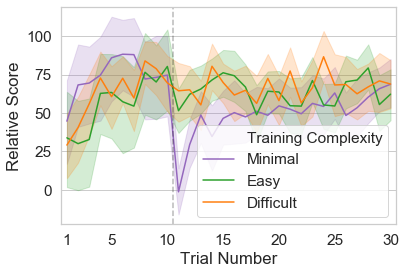

In [24]:
figure(var='score')(learning_curve)

figs/8/learning_curve_backward.pdf
figs/8/learning_curve_backward.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

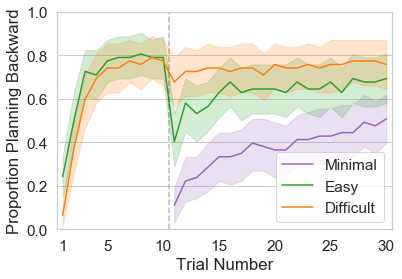

In [25]:
figure(var='backward')(learning_curve)

# Process

## Summary in test block

In [26]:
def report_ratio(df, key, name=None):
    if name is None:
        name = key.replace('_', '-')
    X = df.groupby(['train_height', key]).apply(len)
    rate = 100 * df.groupby('train_height')[key].mean()

    for c in [1,2,3]:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

early_test = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['backward', 'train_height']].mean()\
    .set_index('train_height')

report_ratio(early_test, 'backward', name='backward-early')

wrote "$37.1$\%" to "stats/8/backward-1-percent.tex"
wrote "$63.0$\%" to "stats/8/backward-2-percent.tex"
wrote "$74.4$\%" to "stats/8/backward-3-percent.tex"
wrote "$23.8$\%" to "stats/8/backward-early-1-percent.tex"
wrote "$54.2$\%" to "stats/8/backward-early-2-percent.tex"
wrote "$72.3$\%" to "stats/8/backward-early-3-percent.tex"


In [27]:
write_kruskal('backward')
write_kruskal('backward_early')

wrote "$H = 34.609, p < .001$" to "stats/8/backward-kruskal.tex"
wrote "$H = 39.741, p < .001$" to "stats/8/backward_early-kruskal.tex"


In [28]:
write_independence_test('backward', 'T2', 'T1')
write_independence_test('backward', 'T3', 'T1')
write_independence_test('backward', 'T3', 'T2')

write_independence_test('backward_early', 'T2', 'T1')
write_independence_test('backward_early', 'T3', 'T1')
write_independence_test('backward_early', 'T3', 'T2')

wrote "$d = 0.62, Z = 3.33, p < .001$" to "stats/8/independence-backward-T2-T1.tex"
wrote "$d = 0.91, Z = 4.64, p < .001$" to "stats/8/independence-backward-T3-T1.tex"
wrote "$d = 0.27, Z = 1.50, p = .133$" to "stats/8/independence-backward-T3-T2.tex"
wrote "$d = 0.81, Z = 4.19, p < .001$" to "stats/8/independence-backward_early-T2-T1.tex"
wrote "$d = 1.27, Z = 6.01, p < .001$" to "stats/8/independence-backward_early-T3-T1.tex"
wrote "$d = 0.43, Z = 2.34, p = .019$" to "stats/8/independence-backward_early-T3-T2.tex"


In [29]:
x = pdf.set_index('train_height').backward_early
d1 = x.loc[1]
len(d1)

63

In [30]:
print("Success!")

Success!
